In [1]:
import json
import jsonlines
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy
from scipy.spatial import distance
from scipy.stats import chisquare
from scipy.stats import kstest
import matplotlib
import matplotlib.pyplot as plt
# from sklearn.model_selection import LeaveOneOut
# from sklearn.cross_validation import LeaveOneOut
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import mean_squared_error
%matplotlib inline


def get_top_k_count(real_topk, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json part for real_topk and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    for item in real_topk:
        if(item[0] < top1):
            t1 = t1 + 1
        elif(item[0] < top2):
            t2 = t2 + 1
        elif(item[0] < top3):
            t3 = t3 + 1
        else:
            t4 = t4 + 1
    return [t1, t2, t3, t4]


def get_top_k_count_from_file(json_file, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json file and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    return get_top_k_count(json_file["result"]["real_topk"], top1, top2, top3)


def get_frac_p(real_topk, pred_topk):
    # takes in real_topk and pred_topk and returns list of
    # frac(p)
    res = []
    for i in range(len(real_topk)):
        res.append(real_topk[i][1] / pred_topk[i][0][1])
    return res


def fracp_bin_counter(fracp):
    # takes in the list of all frac(p) and returns list of buckets from 0-1
    # counting by 0.1
    b0 = 0
    b1 = 0
    b2 = 0
    b3 = 0
    b4 = 0
    b5 = 0
    b6 = 0
    b7 = 0
    b8 = 0
    b9 = 0

    for val in fracp:
        if(val <= 0.1):
            b0 = b0 + 1
        elif(val <= 0.2):
            b1 = b1 + 1
        elif(val <= 0.3):
            b2 = b2 + 1
        elif (val <= 0.4):
            b3 = b3 + 1
        elif (val <= 0.5):
            b4 = b4 + 1
        elif (val <= 0.6):
            b5 = b5 + 1
        elif (val <= 0.7):
            b6 = b6 + 1
        elif (val <= 0.8):
            b7 = b7 + 1
        elif (val <= 0.9):
            b8 = b8 + 1
        else:
            b9 = b9 + 1
    # print([b0, b1, b2, b3, b4, b5, b6, b7, b8, b9])
    return [b0, b1, b2, b3, b4, b5, b6, b7, b8, b9]


def fracp_bin_counter_from_file(json_file):
    # takes json file (json structure) and returns bins count
    rtk = json_file["result"]["real_topk"]
    ptk = json_file["result"]["pred_topk"]
    return fracp_bin_counter(get_frac_p(rtk, ptk))


def zero_to_small_num(lst):
    # takes a list and replaces all 0 with a small number
    for i in range(len(lst)):
        if lst[i] == 0:
            lst[i] = 0.0000000000000000000001
    return lst


def get_kld(fp_bin1, fp_bin2):
    # given two list of bin counts (10 long by default)
    # returns KLD value
    return entropy(fp_bin1, fp_bin2)


def get_kld_from_json_file(file1, file2):
    # given two json objects
    # returns KLD value
    # this skips a lot of steps to make it easier
    realtk_1 = file1["result"]["real_topk"]
    predtk_1 = file1["result"]["pred_topk"]
    realtk_2 = file2["result"]["real_topk"]
    predtk_2 = file2["result"]["pred_topk"]

    bins1 = fracp_bin_counter(get_frac_p(realtk_1, predtk_1))
    bins2 = fracp_bin_counter(get_frac_p(realtk_2, predtk_2))
    print(str(bins1) + "                   " + str(bins2))
    # bins1 = zero_to_small_num(bins1)
    # bins2 = zero_to_small_num(bins2)
    print(str(bins1) + "                   " + str(bins2))
    return get_kld(bins1, bins2)


def get_jsd(fp_bin1, fp_bin2):
    # given two list of bin counts, (10 long by default)
    # returns JSD value
    return distance.jensenshannon(fp_bin1, fp_bin2)


def compare_json_files_kld(filename1, filename2):
    # given two file names, get json from it, then use kld
    # returns list of all kld values
    lst = []
    with open(filename1) as f1:
        d1 = json.load(f1)
    with open(filename2) as f2:
        d2 = json.load(f2)
    print(str(len(d1))+"       F2:"+str(len(d2)))

    for d1x in d1:
        for d2x in d2:
            # print("D1: " + str(d1x) + "           D2: " + str(d2x))
            lst.append(get_kld_from_json_file(d1x, d2x))
            print(lst[-1])
    return lst


def list_of_fracp_from_file(filename):
    # given two file names, get json from it, then return list
    # returns list of list of 10 frac p bins
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)

    for d1x in d1:
        lst.append(fracp_bin_counter_from_file(d1x))
    return lst


def list_of_fracp_from_jsonl_file(filename):
    # given two file names of json lines, get json from it, then return list
    # returns list of list of 10 frac p bins
    lst = []
    with jsonlines.open(filename) as reader:
        for obj in reader:
            lst.append(fracp_bin_counter_from_file(obj))
    return lst


def list_of_norm_fracp_from_file(filename):
    # given two file names, get json from it, then return list
    # returns list of list of 10 frac p bins that are normalized
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)

    for d1x in d1:
        bins = fracp_bin_counter_from_file(d1x)
        tot = sum(bins)
        for i in range(10):
            bins[i] = bins[i] / tot
        print(sum(bins))
        lst.append(bins)
    return lst

### List of pickles to use
- "fracp.GPT2-human-25000-pd-normalized.pickle"
- "fracp.GPT2-machine-25000-pd-normalized.pickle"
- "fracp.GROVER-human-15000-pd-normalized.pickle"
- "fracp.GROVER-machine-10000-pd-normalized.pickle"
- "fracp.GPT3-machine-485-pd-normalized.pickle"

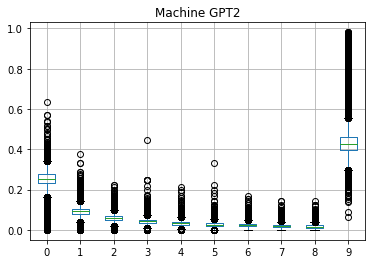

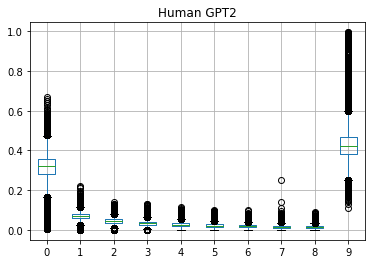

In [2]:
observed = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle")
# print(observed)
# print(expected)
plt.title("Machine GPT2")
observed.boxplot()
plt.subplots(0,2)
plt.title("Human GPT2")
expected.boxplot()

Power_divergenceResult(statistic=0.031895314243821415, pvalue=0.999999999845967)


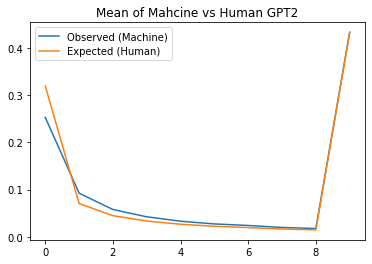

In [3]:
observed_means = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle").mean(axis=0)
expected_means = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").mean(axis=0)

# if not using mean, need to replace expected 0 with small value to avoid div by 0
# expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").replace(0, 0.00000000000000000000000000000001)

chi_res = chisquare(observed_means, expected_means, 0, 0)
print(chi_res)
plt.title("Mean of Mahcine vs Human GPT2")
observed_means.plot(label='Observed (Machine)')
expected_means.plot(label='Expected (Human)')
plt.legend()


###                                Chi Squared Probabilities Table
| df || 0.995 |  0.99 | 0.975 |  0.95 |  0.90 |   0.10 |   0.05 |  0.025 |   0.01 |  0.005 |
|---:||------:|------:|------:|------:|------:|-------:|-------:|-------:|-------:|-------:|
|  1 ||   --- |   --- | 0.001 | 0.004 | 0.016 |  2.706 |  3.841 |  5.024 |  6.635 |  7.879 |
|  2 || 0.010 | 0.020 | 0.051 | 0.103 | 0.211 |  4.605 |  5.991 |  7.378 |  9.210 | 10.597 |
|  3 || 0.072 | 0.115 | 0.216 | 0.352 | 0.584 |  6.251 |  7.815 |  9.348 | 11.345 | 12.838 |
|  4 || 0.207 | 0.297 | 0.484 | 0.711 | 1.064 |  7.779 |  9.488 | 11.143 | 13.277 | 14.860 |
|  5 || 0.412 | 0.554 | 0.831 | 1.145 | 1.610 |  9.236 | 11.070 | 12.833 | 15.086 | 16.750 |
|  6 || 0.676 | 0.872 | 1.237 | 1.635 | 2.204 | 10.645 | 12.592 | 14.449 | 16.812 | 18.548 |
|  7 || 0.989 | 1.239 | 1.690 | 2.167 | 2.833 | 12.017 | 14.067 | 16.013 | 18.475 | 20.278 |
|  8 || 1.344 | 1.646 | 2.180 | 2.733 | 3.490 | 13.362 | 15.507 | 17.535 | 20.090 | 21.955 |
|  9 || 1.735 | 2.088 | 2.700 | 3.325 | 4.168 | 14.684 | 16.919 | 19.023 | 21.666 | 23.589 |

###### Source: https://people.richland.edu/james/lecture/m170/tbl-chi.html

In [4]:
# example https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html
X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)
print(loo.get_n_splits(X))
for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

LeaveOneOut()
2
TRAIN: [1] TEST: [0]
[[3 4]] [[1 2]] [2] [1]
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]] [1] [2]


In [5]:
# o_np = observed.to_numpy().tolist()
# e_np = expected.to_numpy().tolist()
# # print(len(o_np))
# gpt_loo = LeaveOneOut()
# n = gpt_loo.get_n_splits(e_np)
# print(n)
# for train_index, test_index in loo.split(e_np):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = e_np[train_index], e_np[test_index]
#     y_train, y_test = o_np[train_index], o_np[test_index]
#     print(X_train, X_test, y_train, y_test)

In [13]:
def is_chisqr_independent(observed, expected, ddof = 0, axis = 0):
    chi_res = chisquare(observed, expected, 0, 0)
    stat = chi_res[0]
    pval = chi_res[1]
    return chi_res

def average_prediction(obsa, expa):
    adf = pd.DataFrame(expa).mean(axis=0).append(pd.DataFrame(obsa).mean(axis=0))
    ret = adf.mean(axis=0)
    return ret
#     return ret.values.tolist()



'''Calculates the cross validation root mean squared error. If the dataset
is large, uses 10-fold cross validation. Otherwise, uses leave-one-out cross
validation. algorithm is a function that takes in X and y and returns a model.
'''
def get_cross_validation_error_meanx(algorithm, X, y):
    print(X)
    print(type(X))
    print("This is X")
    print("============")
    stat = []
    pv = []
    if len(y) > 10000:
        print('Data contains more than 10000 rows. Using 10-fold cross validation...')
        splitter = KFold(n_splits=100, shuffle=True, random_state=4294967295) #2**32 - 1
        
    else:
        print('Using leave-one-out cross validation...')
        splitter = LeaveOneOut()
    
    for train_indices, test_indices in splitter.split(y):
        print('train_indices')
        print(train_indices)
        print(type(train_indices))
        print(len(train_indices))
        print("============")
        print('test_indices')
        print(test_indices)
        print(type(test_indices))
        print(len(test_indices))
        print("============")
#         print('splitter.split(y)')
#         print(splitter.split(y))
#         print(type(splitter.split(X)))
        print("============")
        #train_X, train_y = X[train_indices], y[train_indices]
        train_y = y[train_indices]
#         print('train_X')
#         print(train_X)
#         print(type(train_X))
        print("============")
        print('train_y')
        print(train_y)
        print(type(train_y))
        print(len(train_y))
        print("============")
        #test_X, test_y = X[test_indices], y[test_indices]
        test_y = y[test_indices]
#         print('test_X')
#         print(test_X)
#         print(type(test_X))
        print("============")
        print('test_y')
        print(test_y)
        print(type(test_y))
        print(len(test_y))
        print("============")
        
#         model = algorithm(train_X, train_y)
#         mse = mean_squared_error(test_y, model.predict(test_X))
#         model = algorithm(train_X, train_y)
#         print(model)
#         print(type(model))
        print("TRY AGIAN WITH MEAN")
        print(test_y.mean())
#         print(type(test_y))
        model = X

        mse = is_chisqr_independent(model, test_y.mean(axis=0))
        stat.append(mse[0])
        pv.append(mse[1])
    return [stat, pv]
#     return sqrt(sum(errors) / len(errors))

def get_cross_validation_error(algorithm, X, y):
    print(X)
    print(type(X))
    print("This is X")
    print("============")
    stat = []
    pv = []
    if len(y) > 10000:
        print('Data contains more than 10000 rows. Using 10-fold cross validation...')
        splitter = KFold(n_splits=100, shuffle=True, random_state=4294967295) #2**32 - 1
        
    else:
        print('Using leave-one-out cross validation...')
        splitter = LeaveOneOut()
    
    for train_indices, test_indices in splitter.split(y):
        print('train_indices')
        print(train_indices)
        print(type(train_indices))
        print(len(train_indices))
        print("============")
        print('test_indices')
        print(test_indices)
        print(type(test_indices))
        print(len(test_indices))
        print("============")
#         print('splitter.split(y)')
#         print(splitter.split(y))
#         print(type(splitter.split(X)))
        print("============")
        #train_X, train_y = X[train_indices], y[train_indices]
        train_y = y[train_indices]
#         print('train_X')
#         print(train_X)
#         print(type(train_X))
        print("============")
        print('train_y')
        print(train_y)
        print(type(train_y))
        print(len(train_y))
        print("============")
        #test_X, test_y = X[test_indices], y[test_indices]
        test_y = y[test_indices]
#         print('test_X')
#         print(test_X)
#         print(type(test_X))
        print("============")
        print('test_y')
        print(test_y)
        print(type(test_y))
        print(len(test_y))
        print("============")
        
#         model = algorithm(train_X, train_y)
#         mse = mean_squared_error(test_y, model.predict(test_X))
#         model = algorithm(train_X, train_y)
#         print(model)
#         print(type(model))
        print("TRY AGIAN WITH MEAN")
        print(test_y.mean())
#         print(type(test_y))
        model = X

        mse = is_chisqr_independent(model, test_y.mean(axis=0))
        stat.append(mse[0])
        pv.append(mse[1])
    return [stat, pv]
#     return sqrt(sum(errors) / len(errors))



def tempname(observed, expected):
    pass

In [14]:
obs = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
expected_means = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").mean(axis=0)
#print(is_chisqr_independent(obs.mean(axis=0), expected_means))
# err = get_cross_validation_error(average_prediction, expected_means.to_numpy(), obs.to_numpy())
err = get_cross_validation_error_meanx(average_prediction, expected_means.to_numpy(), obs.to_numpy())
print(err)

[0.31941638 0.07036604 0.04472994 0.03337982 0.02658552 0.0221755
 0.01945244 0.0165017  0.01453523 0.43285743]
<class 'numpy.ndarray'>
This is X
Data contains more than 10000 rows. Using 10-fold cross validation...
train_indices
[    0     1     2 ... 24996 24997 24998]
<class 'numpy.ndarray'>
24749
test_indices
[  218   224   233   243   259   262   656   697   803   862   870  1073
  1120  1373  1426  1450  1460  1651  1658  1763  1777  1870  1919  1996
  2077  2147  2235  2282  2369  2575  2677  2723  2852  3041  3171  3345
  3361  3422  4387  4526  4552  4668  4673  4689  4895  4934  4987  5035
  5112  5120  5305  5322  5439  5504  5512  5570  5655  5804  5891  5937
  6052  6285  6576  6686  6760  6781  6910  7144  7286  7384  7505  7511
  7537  7612  7677  7736  7784  7820  7951  8091  8099  8104  8119  8291
  8292  8452  8642  8644  8707  8743  8910  8916  8942  9145  9184  9240
  9345  9745  9787  9959 10285 10355 10360 10418 10526 10804 10906 10951
 11012 11182 11261 11401 114

train_y
[[0.20952381 0.06190476 0.04761905 ... 0.03333333 0.02857143 0.51428571]
 [0.27797834 0.10649819 0.05595668 ... 0.01624549 0.01624549 0.39711191]
 [0.27472527 0.0989011  0.05494505 ... 0.02197802 0.01098901 0.37362637]
 ...
 [0.26573427 0.08741259 0.05594406 ... 0.01515152 0.01515152 0.43706294]
 [0.23076923 0.08939709 0.05821206 ... 0.02702703 0.01663202 0.44698545]
 [0.25039872 0.10845295 0.06060606 ... 0.03189793 0.01435407 0.37320574]]
<class 'numpy.ndarray'>
24749
test_y
[[0.2753304  0.09140969 0.0561674  ... 0.0253304  0.0154185  0.39647577]
 [0.23593074 0.09307359 0.06277056 ... 0.01082251 0.02597403 0.41341991]
 [0.25675676 0.10810811 0.10135135 ... 0.         0.03378378 0.35810811]
 ...
 [0.27433628 0.09734513 0.07079646 ... 0.00884956 0.         0.42477876]
 [0.2763596  0.07769145 0.05771365 ... 0.01775805 0.01442841 0.42064373]
 [0.22522523 0.10585586 0.05630631 ... 0.02252252 0.01126126 0.46171171]]
<class 'numpy.ndarray'>
250
TRY AGIAN WITH MEAN
0.1
train_indices
[